In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## EDA + 1st submit

In [6]:
!pip install ../input/talib-package/talib_binary-0.4.19-cp37-cp37m-manylinux1_x86_64.whl
import talib as ta

Processing /kaggle/input/talib-package/talib_binary-0.4.19-cp37-cp37m-manylinux1_x86_64.whl


In [16]:
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import missingno as msno

import statsmodels.api as sm
from pylab import rcParams

from tqdm import tqdm

# import ta
# from talib.ta import add_all_ta_features

In [17]:
data = pd.read_csv('/kaggle/input/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv')
# display(data)

In [18]:
# hold-out validation  2021 전후로 나눔
# train = data[data['Date'] < '2021-01-01']
# val = data[data['Date'] >= '2021-01-01']
train = data.copy()
# print(train.head(3), val.head(3))

In [19]:
display(data)


,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026
...,...,...,...,...,...,...,...,...,...,...,...,...
2332526,20211203_9990,2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816
2332527,20211203_9991,2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478
2332528,20211203_9993,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302
2332529,20211203_9994,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,False,0.009098


<AxesSubplot:>

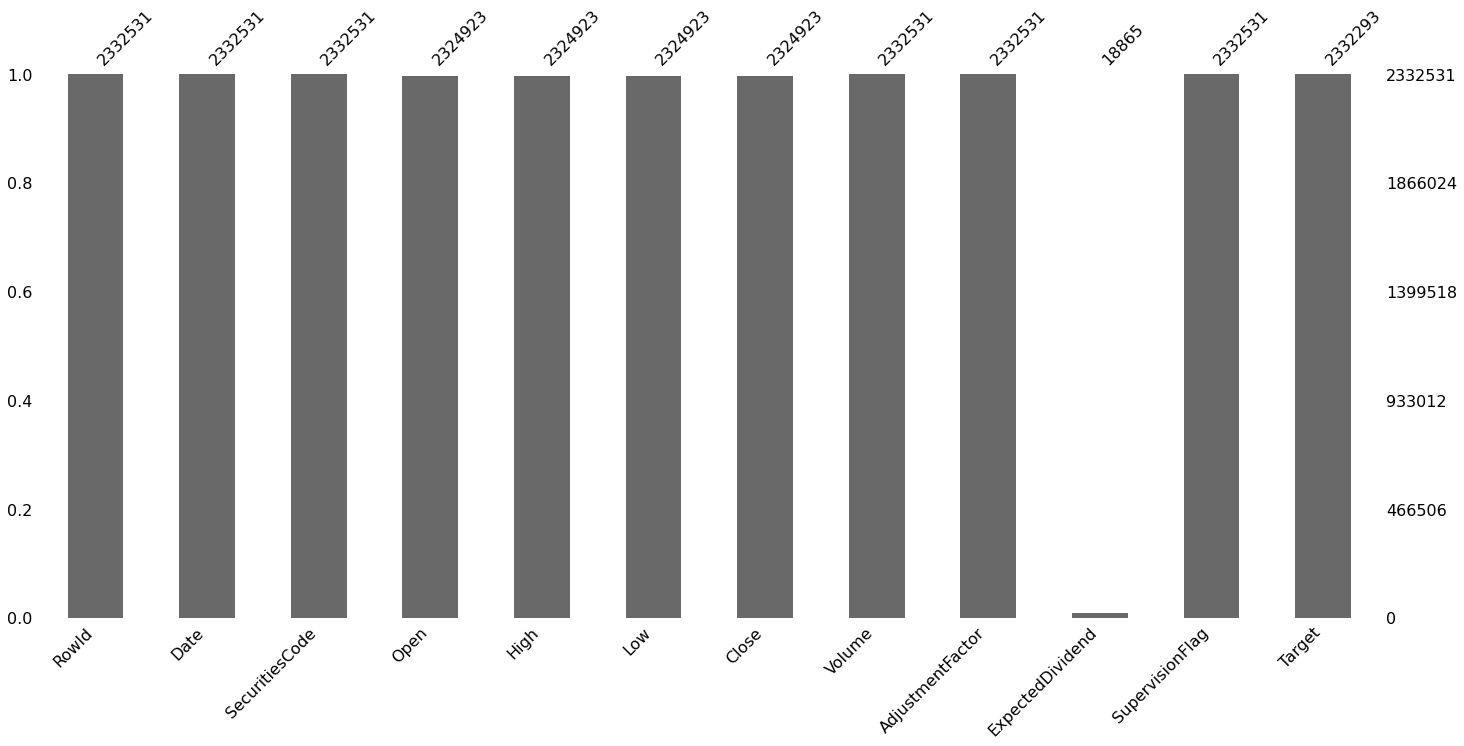

In [20]:
msno.bar(data)

In [21]:
%%time
# fill the nans
df_list = []
for code in tqdm(np.sort(data.SecuritiesCode.unique())):
    df_list.append(train.loc[train.SecuritiesCode == code, :].fillna(method='ffill'))


df_filled = pd.concat(df_list)        
df_filled.to_csv('train_filled.csv')
df_filled

100%|██████████| 2000/2000 [00:09<00:00, 217.44it/s]


CPU times: user 35.3 s, sys: 442 ms, total: 35.7 s
Wall time: 35.7 s


,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1865,20170105_1301,2017-01-05,1301,2743.0,2747.0,2735.0,2738.0,17900,1.0,NaN,False,0.002920
3730,20170106_1301,2017-01-06,1301,2734.0,2744.0,2720.0,2740.0,19900,1.0,NaN,False,-0.001092
5595,20170110_1301,2017-01-10,1301,2745.0,2754.0,2735.0,2748.0,24200,1.0,NaN,False,-0.005100
7460,20170111_1301,2017-01-11,1301,2748.0,2752.0,2737.0,2745.0,9300,1.0,NaN,False,-0.003295
...,...,...,...,...,...,...,...,...,...,...,...,...
2324530,20211129_9997,2021-11-29,9997,678.0,679.0,665.0,668.0,320800,1.0,9.5,False,0.026987
2326530,20211130_9997,2021-11-30,9997,670.0,689.0,667.0,667.0,296300,1.0,9.5,False,-0.001460
2328530,20211201_9997,2021-12-01,9997,661.0,688.0,660.0,685.0,339100,1.0,9.5,False,0.017544
2330530,20211202_9997,2021-12-02,9997,681.0,692.0,680.0,684.0,342900,1.0,9.5,False,0.014368


In [22]:
df_filled.sort_values('RowId')

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026
...,...,...,...,...,...,...,...,...,...,...,...,...
2332526,20211203_9990,2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,0.0,False,0.034816
2332527,20211203_9991,2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,15.0,False,0.025478
2332528,20211203_9993,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,13.5,False,-0.004302
2332529,20211203_9994,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,24.0,False,0.009098


In [23]:
def Code(num):
    return df_filled.loc[df_filled.SecuritiesCode == num, :]
    # Code에서 fillna 하여 return
    
Code(1377)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026
1869,20170105_1377,2017-01-05,1377,3340.0,3355.0,3295.0,3305.0,155700,1.0,NaN,False,0.004525
3734,20170106_1377,2017-01-06,1377,3320.0,3335.0,3260.0,3315.0,153300,1.0,NaN,False,-0.033033
5599,20170110_1377,2017-01-10,1377,3325.0,3360.0,3310.0,3330.0,192500,1.0,NaN,False,0.046584
7464,20170111_1377,2017-01-11,1377,3260.0,3295.0,3180.0,3220.0,741200,1.0,NaN,False,-0.010386
...,...,...,...,...,...,...,...,...,...,...,...,...
2322536,20211129_1377,2021-11-29,1377,3140.0,3160.0,3110.0,3125.0,127100,1.0,18.0,False,0.003200
2324536,20211130_1377,2021-11-30,1377,3130.0,3190.0,3115.0,3125.0,115000,1.0,18.0,False,-0.007974
2326536,20211201_1377,2021-12-01,1377,3120.0,3145.0,3110.0,3135.0,61800,1.0,18.0,False,0.019293
2328536,20211202_1377,2021-12-02,1377,3110.0,3150.0,3110.0,3110.0,88700,1.0,18.0,False,0.009464


In [32]:
# TA
df_ta = df_filled.copy()
rsi = ta.RSI(df_ta['Close'])
rsi[rsi.isna()]

0         NaN
1865      NaN
3730      NaN
5595      NaN
7460      NaN
           ..
2324530   NaN
2326530   NaN
2328530   NaN
2330530   NaN
2332530   NaN
Length: 1976258, dtype: float64

In [ ]:
Code(1377)['Close'].ewm

In [ ]:
def add_features(dfc):
    df = dfc.copy()
    # shadows
    df['upper_shadow'] = df['High'] - np.maximum(df['Open'], df['Close'])
    df['lower_shadow'] = np.minimum(df['Open'], df['Close']) - df['Low']
    
    # lagged features
    # 날짜 단위이므로 7일전, 30일전, 180일전, 360일전 
    # lagged close, target (target 은 정확히 무엇? return인가)
    
    # lagged ema
    df['Date'] = pd.to_datetime(df['Date'])
    
    # volatility
    
    # rsi
    
    
    
    return df

co_train = add_features(train)
# co_train

In [ ]:
co_train.loc[co_train.SecuritiesCode == 1377, ['Date','Close']].fillna(method='ffill').plot(x='Date', y='Close')

In [ ]:
norm_close.plot()

In [ ]:
co_train.loc[co_train.SecuritiesCode == 1377, ['Target']].plot()

In [ ]:
co_train.loc[co_train.SecuritiesCode == 1377, ['Target']]

In [ ]:
# Autocorrelation test
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(co_train.loc[co_train.SecuritiesCode == 1377, ['Target']], lags=[2,1000])

acf로는 연관성이 보이지 않는다.

In [ ]:
co_train.loc[co_train.SecuritiesCode == 1377, ['Date','Close']].fillna(method='ffill')

In [ ]:
close = co_train.loc[co_train.SecuritiesCode == 1377, ['Date','Close']].fillna(method='ffill').set_index('Date')
close.index

In [ ]:
sm.plot?

In [ ]:
rcParams['figure.figsize'] = 10, 8
sm.tsa.seasonal_decompose(Code(1301)['Close'], period=100).plot()
plt.show()

In [ ]:
Code(9991)['Close'].plot()

In [ ]:
def seasonal_resid_std(series, start, end, grid):
    x, y = [], []
    for p in range(start, end, grid):
        decomposed = sm.tsa.seasonal_decompose(series, period=p)
        rstd = np.std(decomposed.resid)
#         print(f'period: {p} days, residual std:', rstd)
        x.append(p)
        y.append(rstd)
        
    # plot result
    plt.figure(figsize=(7,4))
    plt.plot(x, y)
    plt.xlabel('period (days)')
    plt.ylabel('STD')
    
    return x, y

# 1377, 9991
x, y = seasonal_resid_std(Code(1301)['Close'], 7, 360, 10)

In [ ]:
# 각 종목별 seasonal trend 파악

In [ ]:
code_plot

In [ ]:
# 시각화
def code_plot(number, y='Close'):
    ex1 = co_train[co_train.SecuritiesCode == number]
    plt.figure(figsize=(8,4))
    plt.plot(ex1.Date, ex1[y])
    plt.xlabel('Date')
    plt.ylabel(y)
#     plt.yscale('log')
    
    
code_plot(1301,'Close')

base model - lgbm (maybe ensemble with nn?)
features - close + lagged features + window

feature 추가할것
1. Lagged features
2. lagged ema
3. shadows O

**feature importance check** 해보기

**Autocorrelation**  
요일, 월 정도 추가 
ACF 적용해서 lagged 어느정도 적용하는게 좋은지 판단하기.

features should be normalized - StandardScaler

In [ ]:
def preprocess(df, train=True):
    dfc = df.copy()
    
    # remove columns - Date removed temporarily
    dfc = dfc.drop(columns=['Date', 'RowId', 'AdjustmentFactor', 'ExpectedDividend', 'SupervisionFlag'])
    stdsc = StandardScaler()
    ordinal = OrdinalEncoder()

    target = ['Target']
    ord_features = ['SecuritiesCode']
    scaled_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'upper_shadow', 'lower_shadow']

    date_code_ord = ordinal.fit_transform(dfc.loc[:,ord_features])
    scaled = stdsc.fit_transform(dfc.loc[:,scaled_features])
    dfc_scaled = pd.concat([pd.DataFrame(date_code_ord, columns=ord_features),
                            pd.DataFrame(scaled, columns=scaled_features)], axis=1)
    
    if train:
        y = dfc.loc[:,target]
        return dfc_scaled, y
    else:
        return dfc_scaled

X_scaled, y = preprocess(co_train)

X_scaled

In [ ]:
# base model - lgbm 
lgb = LGBMRegressor().fit(X_scaled, y)


### Time-series CV

In [ ]:
import jpx_tokyo_market_prediction
env = jpx_tokyo_market_prediction.make_env()
iter_test = env.iter_test()

In [ ]:
for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:
    feat = add_features(prices)
    X = preprocess(feat, train=False)

    # X, y
    X['Target'] = lgb.predict(X)
    X['Rank'] = (X['Target'].rank(method='average', ascending=False)-1).astype(int)
    sample_prediction['Rank'] = X['Rank'].values
#     display(sample_prediction)
    env.predict(sample_prediction)

In [ ]:
# code_plot(1301,'Close')
for num in [1332, 1333, 1375, 1376]:
    code_plot(num, 'Close')


In [ ]:
for num in [1301, 1332]:
    code_plot(num, 'Close')